# Hypothesis Testing and Regression Code
This notebook contains the code for the Hypothesis Testing and Regression section of the project (Subsections 2).

In [1]:
import pandas as pd
import altair as alt
import numpy as np
import statsmodels.api as sm
import geopandas as gpd
import plotly.express as px
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
kof_df = pd.read_csv('Datasets/KOF_clean.csv')

dataset_list = ['BOVESPA-BRA-Clean', 'CAC40-FRA-Clean', 'DAX30-DEU-Clean', 'HangSeng-HKG-Clean', 
    'Nikkei225-JPN-Clean', 'Shanghai-CHN-Clean', 'Nifty50-IND-Clean', 'S&P500-USA-Clean',
    'NASI-KEN-Clean', 'MASI-MAR-Clean', 'FTSE_JSE-ZAF-Clean']

sp_df = pd.read_csv('Datasets/S&P500-USA-Clean.csv')
countries_df = pd.DataFrame(columns=['year', 'YoY Change', 'code'])
for df_name in dataset_list:
    df = pd.read_csv('./Datasets/' + df_name + '.csv')
    countries_df = pd.concat([countries_df, df])

kof_df = kof_df.merge(countries_df, on=['year', 'code'])

kof_df.head()

/var/folders/1j/4c9y4tt55lz4k_ppwcz53ks80000gn/T/ipykernel_67097/996202071.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  countries_df = pd.concat([countries_df, df])


,code,country,year,KOFGI,KOFGIdf,KOFGIdj,KOFEcGI,KOFEcGIdf,KOFEcGIdj,KOFTrGI,...,KOFInGIdf,KOFInGIdj,KOFCuGI,KOFCuGIdf,KOFCuGIdj,KOFPoGI,KOFPoGIdf,KOFPoGIdj,YoY Change,volatility
0,BRA,Brazil,1995,49.0,45.0,54.0,30.0,24.0,36.0,30.0,...,31.0,55.0,40.0,37.0,44.0,82.0,84.0,80.0,2.071614,57.543029
1,BRA,Brazil,1996,50.0,46.0,55.0,31.0,25.0,37.0,29.0,...,31.0,60.0,41.0,37.0,44.0,84.0,87.0,81.0,58.436023,23.058225
2,BRA,Brazil,1997,52.0,48.0,56.0,32.0,26.0,38.0,29.0,...,44.0,63.0,42.0,38.0,45.0,83.0,86.0,81.0,50.672130,46.267413
3,BRA,Brazil,1998,52.0,48.0,57.0,34.0,27.0,40.0,28.0,...,45.0,63.0,43.0,40.0,45.0,83.0,84.0,82.0,-33.759542,57.063254
4,BRA,Brazil,1999,54.0,50.0,58.0,37.0,33.0,41.0,28.0,...,47.0,63.0,44.0,42.0,46.0,83.0,84.0,83.0,143.877845,48.994485


In [3]:
# Create the lagged Volatility variable
kof_df['volatility_lagged'] = kof_df.groupby('code')['volatility'].shift(1)

# Drop the rows with missing values after shifting
kof_df = kof_df.dropna(subset=['volatility_lagged'])
# Define the independent variables and add a constant term
X = kof_df[['volatility_lagged', 'KOFFiGI']]
X = sm.add_constant(X)

# Define the dependent variable
y = kof_df['volatility']

# Fit the regression model
model = sm.OLS(y, X).fit()
# Get the summary of the regression model
model_summary = model.summary()

# Print the regression model summary
print(model_summary)

# Perform hypothesis testing
# Test if the coefficients of Volatility_lagged and KOFFiGI are jointly significantly different from zero
hypotheses = '(volatility_lagged = 0), (KOFFiGI = 0)'
f_test_result = model.f_test(hypotheses)

# Print the F-test result
print(f'Test for Hypotheses: {hypotheses}')
print(f'F-test result: {f_test_result}')

                            OLS Regression Results                            
Dep. Variable:             volatility   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     38.71
Date:                Sat, 16 Dec 2023   Prob (F-statistic):           1.48e-15
Time:                        23:24:48   Log-Likelihood:                -988.23
No. Observations:                 281   AIC:                             1982.
Df Residuals:                     278   BIC:                             1993.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.5113      2.09

In [4]:
#Lets have a look at the df and WorldBank merged 
kof_df = pd.read_csv('./Datasets/KOF_World_Bank_merged.csv')
kof_df = kof_df.sort_values(by=['country', 'year'])

In [ ]:
# Map visualization to see the difference of KOFGI before 2008 and after for different countries.
# Input not included due to large file size.
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_data = world.merge(kof_df, left_on='iso_a3', right_on='code')
kofgi_range = [kof_df['KOFGI'].min(), kof_df['KOFGI'].max()]

fig = px.choropleth(world_data,
                    geojson=world_data.geometry,
                    locations=world_data.index,
                    color='KOFGI',
                    hover_name='country',
                    animation_frame='year',
                    color_continuous_scale='OrRd',
                    range_color=kofgi_range,  
                    projection='natural earth')

fig.update_geos(visible=True, showcountries=True, showcoastlines=True, showland=True, fitbounds="locations")

fig.update_layout(title='Globalisation Index Over Years',
                  margin={"r":0,"t":30,"l":0,"b":0})

steps = [dict(method='animate',
              args=[[year], {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate'}],
              label=str(year)) for year in sorted(kof_df['year'].unique())]

sliders = [dict(active=0, pad={"t": 1}, steps=steps)]

fig.update_layout(sliders=sliders)

fig.show()

In [6]:
# Hypothesis: "The 2008 financial crisis resulted in a significant increase in percentage change among countries, and this heightened percentage change persisted in the post-crisis period."
data_pre_2008 = kof_df[kof_df['year'] < 2008]
data_post_2008 = kof_df[kof_df['year'] >= 2008]

# Calculate the mean percentage change for each period
mean_pre_2008 = data_pre_2008['Pct Change'].mean()
mean_post_2008 = data_post_2008['Pct Change'].mean()

# Perform a t-test
t_stat, p_value = ttest_ind(data_pre_2008['Pct Change'], data_post_2008['Pct Change'], nan_policy='omit', equal_var=False)

# Print the results
print(f"Mean Percentage Change Pre-2008: {mean_pre_2008}")
print(f"Mean Percentage Change Post-2008: {mean_post_2008}")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")
if p_value < 0.05:
    print("There is a significant difference in percentage change before and after 2008.")
else:
    print("There is no significant difference in percentage change before and after 2008.")

Mean Percentage Change Pre-2008: 18.102599650482837
Mean Percentage Change Post-2008: 2.3172412783185146
T-Statistic: 8.162260684792411, P-Value: 7.604376454880282e-16
There is a significant difference in percentage change before and after 2008.


/var/folders/1j/4c9y4tt55lz4k_ppwcz53ks80000gn/T/ipykernel_67097/1458123952.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1j/4c9y4tt55lz4k_ppwcz53ks80000gn/T/ipykernel_67097/1458123952.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/andrew/anaconda3/envs/les-pingouins/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/andrew/

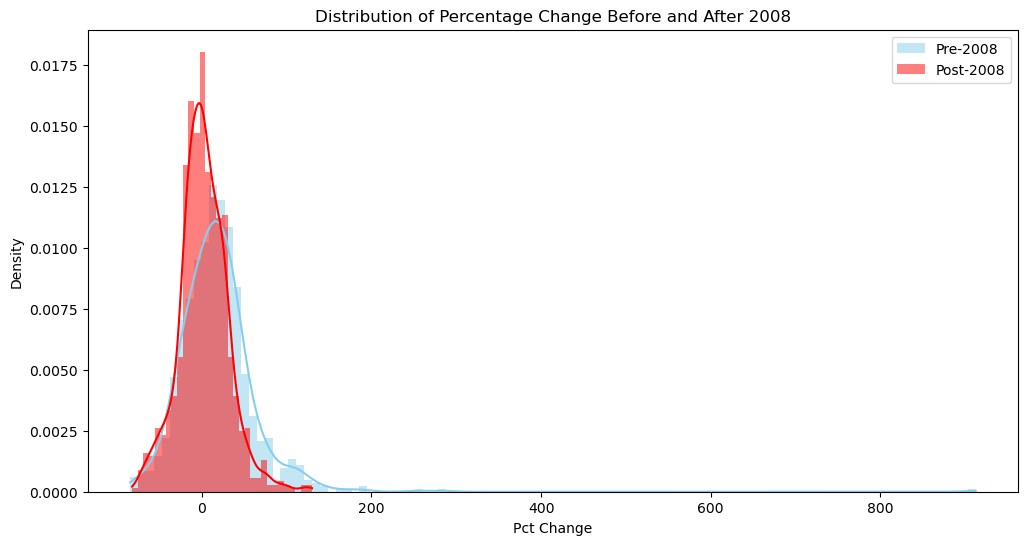

In [7]:
data_pre_2008['Period'] = 'Pre-2008'
data_post_2008['Period'] = 'Post-2008'
combined_data = pd.concat([data_pre_2008, data_post_2008])

plt.figure(figsize=(12, 6))

# Histogram and density for Pre-2008
sns.histplot(combined_data[combined_data['Period'] == 'Pre-2008']['Pct Change'], 
             color="skyblue", label="Pre-2008", kde=True, stat="density", linewidth=0)

# Histogram and density for Post-2008
sns.histplot(combined_data[combined_data['Period'] == 'Post-2008']['Pct Change'], 
             color="red", label="Post-2008", kde=True, stat="density", linewidth=0)

plt.title('Distribution of Percentage Change Before and After 2008')
plt.xlabel('Pct Change')
plt.ylabel('Density')
plt.legend()
plt.show()

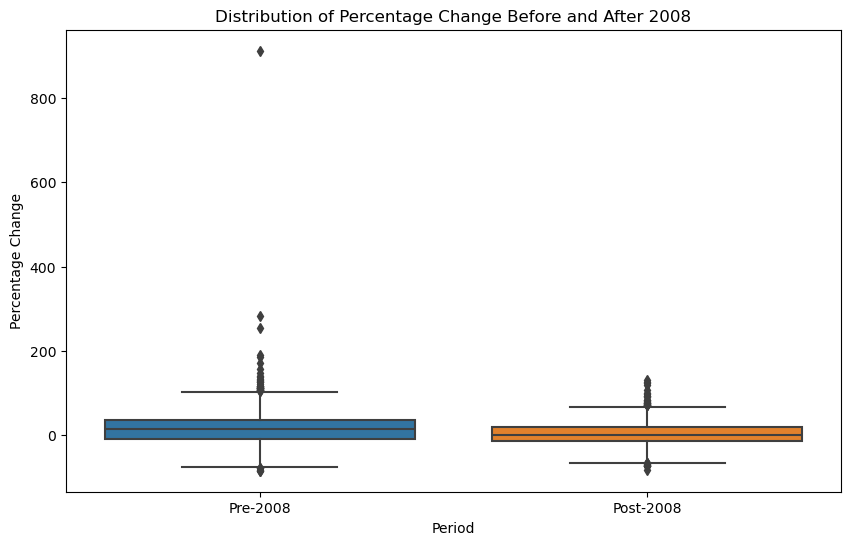

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Period', y='Pct Change', data=combined_data)
plt.title('Distribution of Percentage Change Before and After 2008')
plt.xlabel('Period')
plt.ylabel('Percentage Change')

# Set the limits for the y-axis to zoom in. Adjust the values as needed.
#plt.ylim(-100, 1000)  # Replace ymin and ymax with the desired minimum and maximum values

plt.show()